# Imports

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import QualityReport
from tensorflow.keras.models import Sequential
from sdmetrics.reports.single_table import QualityReport
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Logistic Regresss is not yet supported by SHAP
import shap

## Load the dataset


In [84]:
df = pd.read_csv('../dataset/strokeDataSet.csv')

# Data Cleaning

In [85]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [86]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [87]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### age:
    Mean age is 43.2 years, suggesting the dataset includes both younger and older adults. \
    Std Dev of 22.6 is large, age is widely spread. \
    Min value is 0.08: possibly an infant. \
    Max is 82: includes elderly individuals, a known stroke risk group.


### avg_glucose_level:
    Mean glucose is 106.15 mg/dL. \
    Std Dev is 45.28: indicates significant variation. \
    Max of 271.74 is very high: suggests presence of diabetic/hyperglycemic individuals. \

High glucose levels are risk factors for stroke, this feature may be important in modeling.

### bmi (Body Mass Index)
    Mean is 28.89: close to the overweight range (25–29.9). \
    Max is 97.6: likely indicates extreme obesity. \
    Std Dev is 7.85: some individuals may be underweight or obese.

BMI is a known cardiovascular risk factor, useful for stroke prediction.

### stroke (target variable)
    Mean of 0.049 = 4.9% of patients had a stroke.
    Values are only 0 or 1: this is a binary classification task.
    Highly imbalanced: 95% non-stroke, 5% stroke.

Class imbalance is a challenge, models will need techniques like SMOTE or class weighting.

In [88]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [89]:
df.duplicated().sum()
df = df[df['gender'] != 'Other'] # there is only 1 Other gender, so we can drop it
df.dropna(subset=['bmi'], inplace=True)
print(df['stroke'].value_counts())


stroke
0    4699
1     209
Name: count, dtype: int64


### Data Overview & Cleaning
This dataset contains a total of 5,110 rows with no duplicate, and the 'bmi' parameter has 201 missing values. These missing values were filled using the median, based on the assumption that the individuals with missing 'bmi' entries have typical or average bmi values.

The dataset is heavily imbalanced:

    Stroke (1): 209 samples (~4.3%)

    No Stroke (0): 4699 samples (~95.7%)

This creates major issues:

- Machine learning models tend to favor the majority class, ignoring strokes

- Metrics like accuracy become misleading: a model that predicts "no stroke" 100% of the time would still have ~95% accuracy

### Columns:
1) id: unique identifier
2) gender: "Male", "Female"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

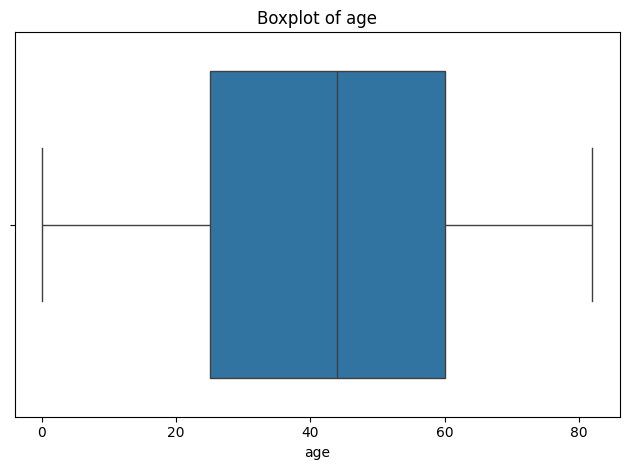

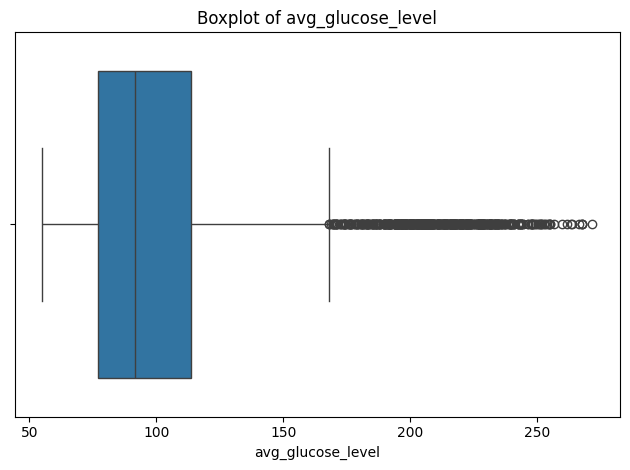

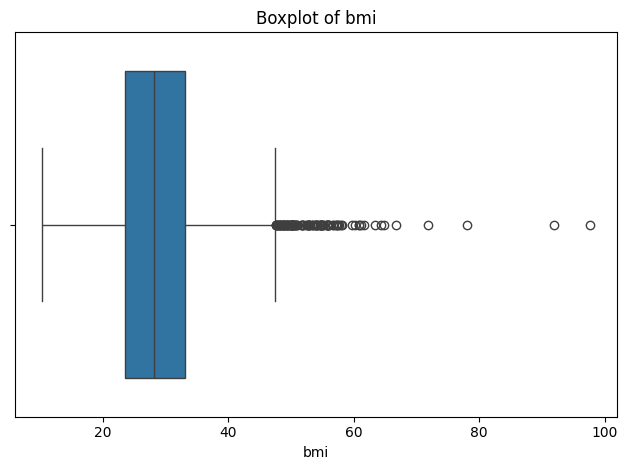

In [90]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.savefig(f'boxplot_{col}.png')
    plt.tight_layout()
    plt.show()


### Interpret boxplots

Boxplots show outliers in bmi and glucose level, but this is reflect the real patient conditions. A stroke patient may actually have a BMI of 90 or glucose of 270, so removing these would hide critical clinical cases!

They are rare but valid, outliers in this dataset can help catch severe cases that models should learn.

# EDA

### Univariate Distribution

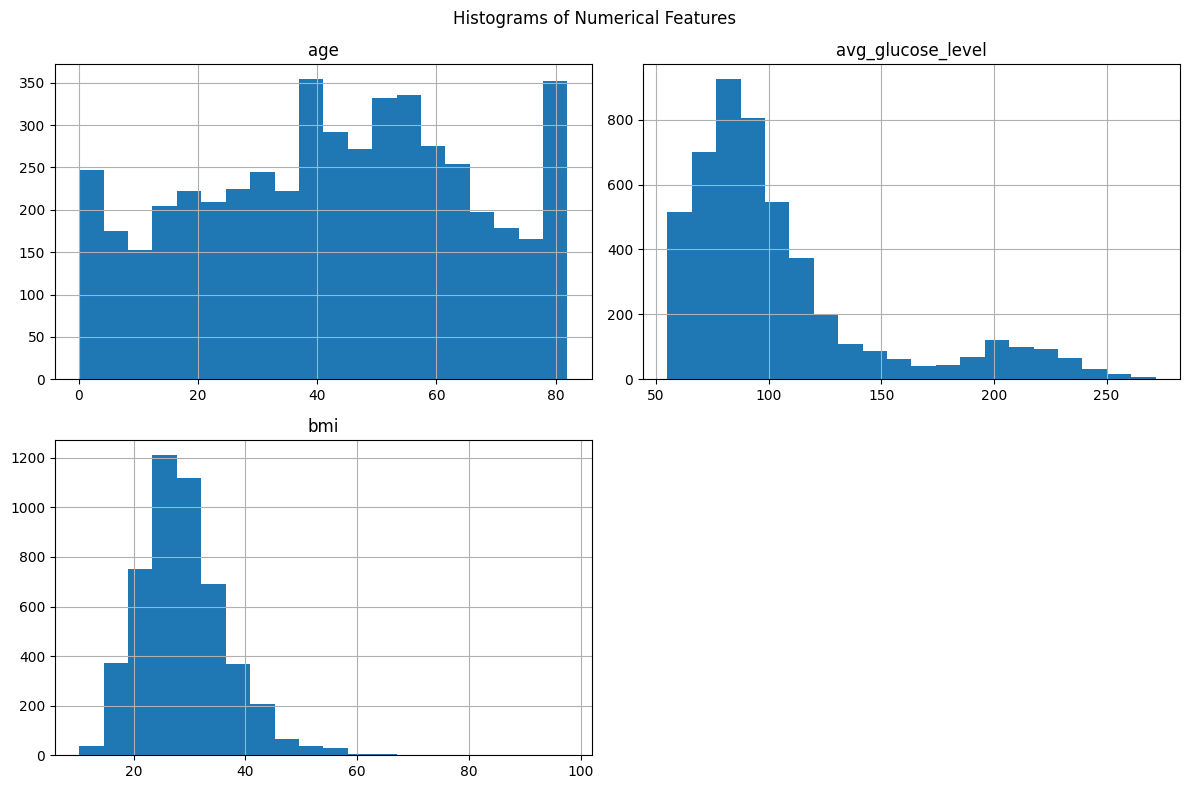

In [91]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.savefig('histograms_numerical_features.png')
plt.tight_layout()
plt.show()

Numerical histograms: "age, avg_glucose_level, bmi" show right-skewed distributions, especially "avg_glucose_level".

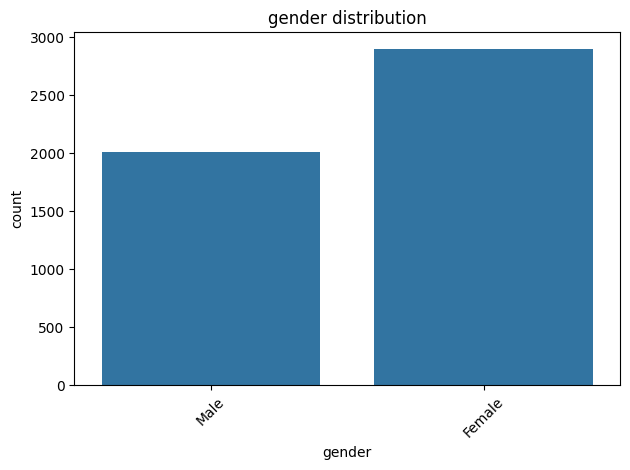

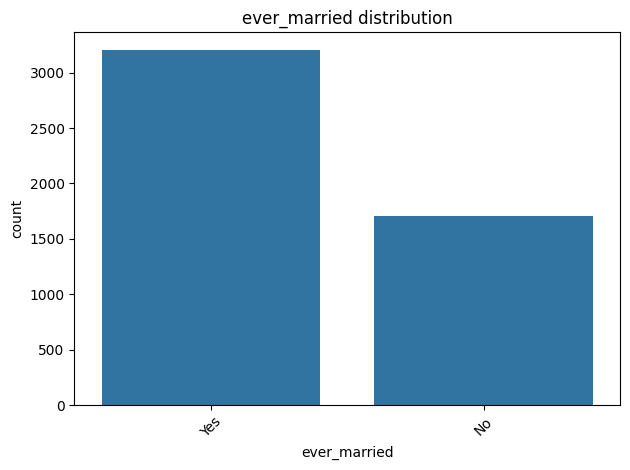

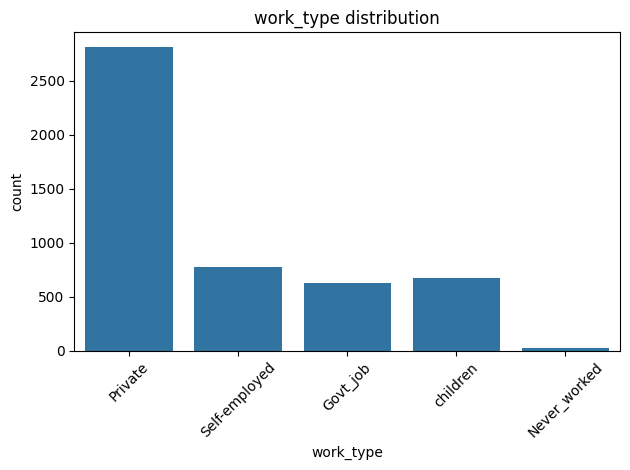

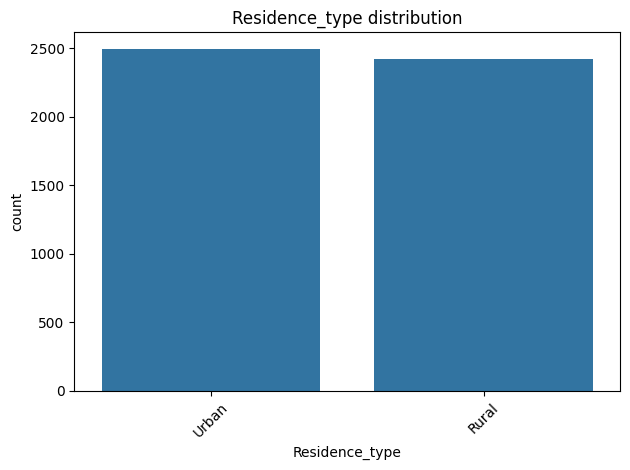

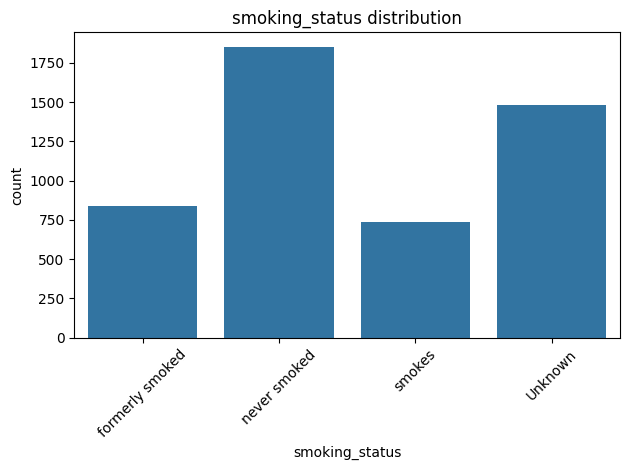

In [92]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'stroke']
for col in categorical_cols:
    
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.xticks(rotation=45)
    plt.savefig(f'countplot_{col}.png')
    plt.tight_layout()
    plt.show()

Categorical countplots like gender, smoking_status, work_type show: most patients are female and have never smoked. Majority work in the private sector.

### Bivariate Analysis

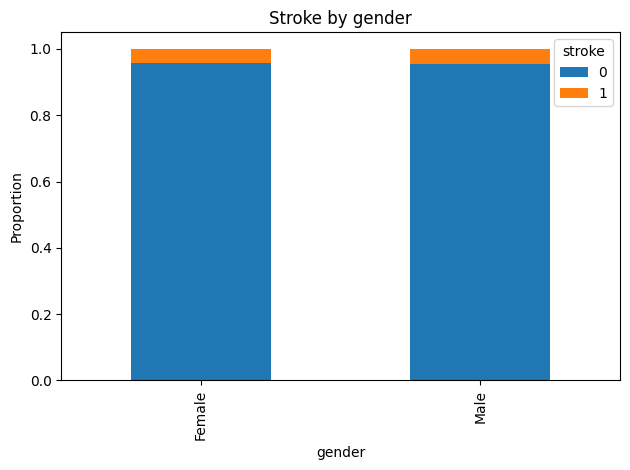

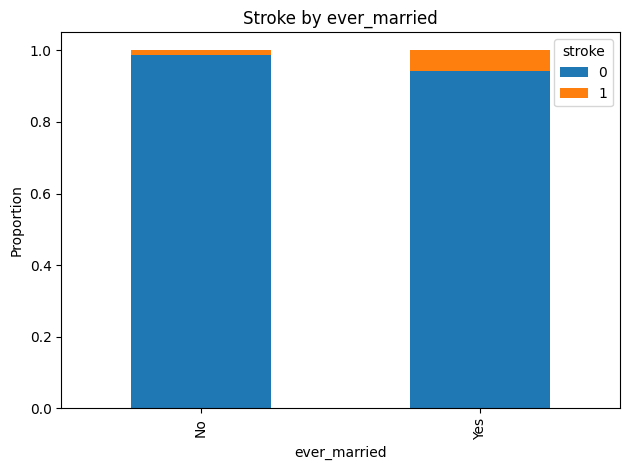

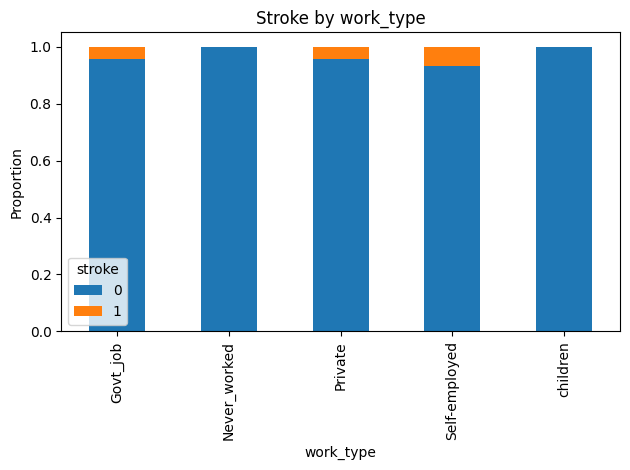

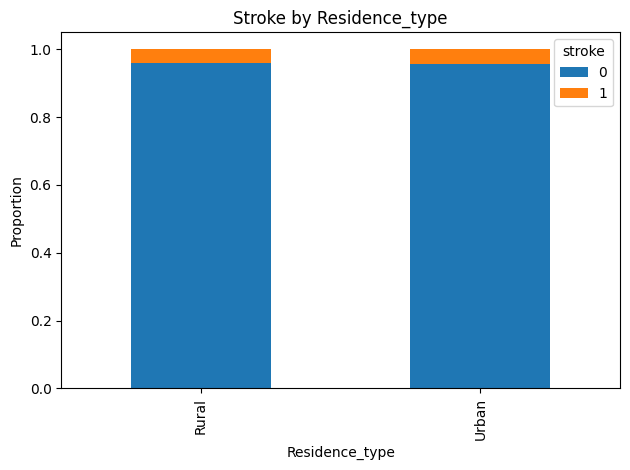

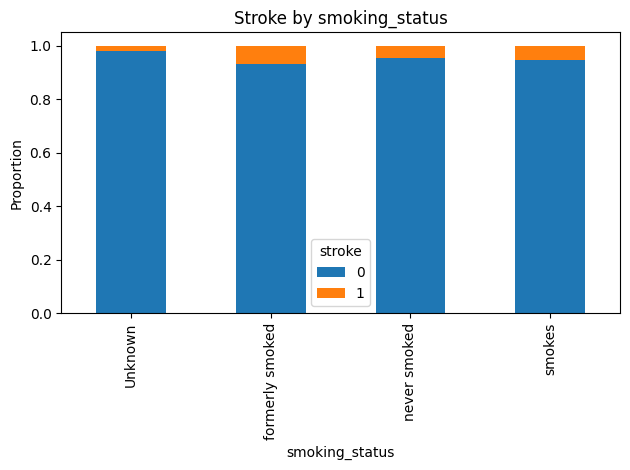

In [93]:
for col in categorical_cols:
    pd.crosstab(df[col], df['stroke'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Stroke by {col}')
    plt.ylabel('Proportion')
    plt.savefig(f'stroke_by_{col}.png')
    plt.tight_layout()
    plt.show()

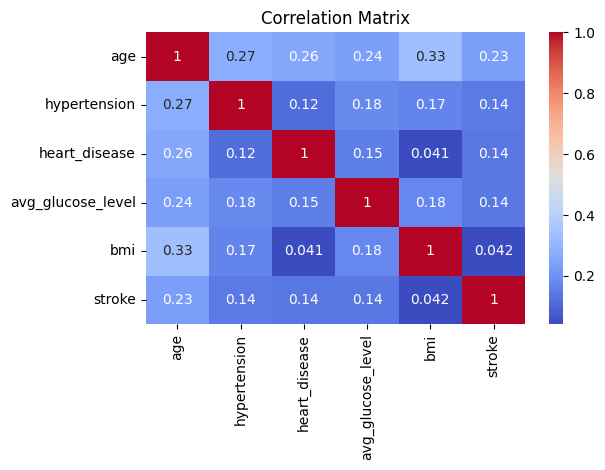

In [94]:
corr = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.tight_layout()  
plt.show()

### Summary of Bivariate Analysis
| Feature        | Strength of Association with Stroke  | Notes                                                     |
| -------------- | -----------------------------------  | ------------------------------------------------------    |
| Age            | Strong                               | Older people much more likely to have stroke              |
| Glucose Level  | Moderate                             | High glucose is a risk factor                             |
| Smoking Status | Moderate                             | "Formerly smoked" and "smokes" show elevated stroke risk  |
| Hypertension   | Moderate                             | Medically important though correlation is weak            |
| Heart Disease  | Moderate                             | Similar to hypertension                                   |
| Ever Married   | Weak to Moderate                     | Marginal relationship with stroke
| Work Type      | Weak to Moderate                     | "Self-employed" and "Govt job" higher                     |
| BMI            | Weak                                 | Not strongly correlated alone                             |
| Gender         | Very Weak                            | No major difference                                       |
| Residence Type | None                                 | Urban and rural similar                                   |


# Train Data

### Formal Feature Selection


In [95]:
class FormalFeatureSelection:
    def __init__(self, df, features, label):
        self.df = df
        self.features = features
        self.label = label
    
    def getX(self):
        return self.features
    
    def getY(self):
        return self.labels
        
    def selectTopFeatures(self, top_n_anova=5, top_n_chi=5, top_n_rf=5, include_ref=5):
        self.featureSelectionSummary()
        top_features = self.feature_selection_summary
        anova_top = (
            top_features["Anova F"].sort_values(ascending=False).head(top_n_anova).index
        )
        chi2_top = (
            top_features["CHI2"].sort_values(ascending=False).head(top_n_chi).index
        )
        rf_top = (
            top_features["RF Importance"].sort_values(ascending=False).head(top_n_rf).index
        )
        rfe_top = (
            top_features["RFE Support"].sort_values(ascending=False).head(include_ref).index
        )
        self.top_features = set(anova_top).union(chi2_top).union(rf_top).union(rfe_top)
        display(top_features.loc[list(self.top_features)])

    def featureSelectionSummary(self):
        features = self.df.drop(columns=self.label)
        self.labels = self.df[self.label]
        self.features = pd.get_dummies(features)        
        
        #Anova F-Test
        skb_f = SelectKBest(score_func=f_classif, k="all").fit(self.features, self.labels)
        anova_scores = pd.Series(skb_f.scores_, index=self.features.columns).sort_values(ascending=False)

        #Normalize for Chi2
        scaler = MinMaxScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(self.features), columns=self.features.columns
        )
        
        #Chi2
        skb_chi2 = SelectKBest(score_func=chi2, k="all").fit(features_scaled, self.labels)
        chi2_scores = pd.Series(skb_chi2.scores_, index=self.features.columns).sort_values(ascending=False)

        #RandomForestImportances
        rf = RandomForestClassifier(random_state=0)
        rf.fit(self.features, self.labels)
        rf_scores = pd.Series(
            rf.feature_importances_, index=self.features.columns
        ).sort_values(ascending=False)

        #RFE - Logistic Regression
        lr = LogisticRegression(max_iter=4000)
        rfe = RFE(estimator=lr, n_features_to_select=10)
        rfe.fit(self.features, self.labels)
        rfe_support = pd.Series(rfe.support_, index=self.features.columns)

        
        self.feature_selection_summary = pd.DataFrame(
            {
                "Anova F": anova_scores,
                "CHI2": chi2_scores,
                "RF Importance": rf_scores,
                "RFE Support": rfe_support.astype(bool)
            }
        )
        

### Generate synthetic stroke data

In [96]:
'''
Due to the severe class imbalance (stroke = 4.3%), we employed SDV's GaussianCopula to generate 2,000 additional stroke-positive records, creating a 2:1 ratio between synthetic and real minority data. 
This approach improved representation of the minority class while preserving feature distribution and inter-feature relationships, as evidenced by an SDV quality score of around 85%. 
This moderately balanced dataset allows for improved model sensitivity without sacrificing clinical relevance.
'''

if 'id' in df.columns:
    df = df.drop(columns=['id'])
df_stroke = df[df['stroke'] == 1]

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_stroke)
metadata_dict = metadata.to_dict()

synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(df_stroke)
synthetic_data = synthesizer.sample(num_rows=2000)

report = QualityReport()
report.generate(real_data=df_stroke, synthetic_data=synthetic_data, metadata=metadata_dict)

print(f"Synthetic stroke data quality score: {report.get_score():.3f}")

df_combined = pd.concat([df, synthetic_data], ignore_index=True)

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:167: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:133: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 704.11it/s]|
Column Shapes Score: 86.32%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 272.62it/s]|
Column Pair Trends Score: 76.31%

Overall Score (Average): 81.31%

Synthetic stroke data quality score: 0.813


New dataset ratio

    Stroke (1):	2,209	(~31.2%)

    No Stroke (0):	4,699	(~68.8%)

This still reflects the real-world imbalance, but:

- Greatly improves model sensitivity (detects more true strokes)

- Avoids overfitting to synthetic data

- Preserves data realism, especially since SDV quality is high (~85%)

Due to the severe class imbalance (stroke = 4.3%), we employed SDV's GaussianCopula to generate 2,000 additional stroke-positive records, creating a 2:1 ratio between synthetic and real minority data. This approach improved representation of the minority class while preserving feature distribution and inter-feature relationships, as evidenced by an SDV quality score around 85%. This moderately balanced dataset allows for improved model sensitivity without sacrificing clinical relevance.

### combine with feature selection

In [97]:
fs = FormalFeatureSelection(df_combined.copy(deep=True), df_combined.columns.drop('stroke').tolist(), 'stroke')
display("Running the following tests: AnovaF, CHI2, RF Importance and RFE Support for selecting the features")
display("Based on the scores selecting the following top features")
fs.selectTopFeatures(top_n_anova=10)


'Running the following tests: AnovaF, CHI2, RF Importance and RFE Support for selecting the features'

'Based on the scores selecting the following top features'

,Anova F,CHI2,RF Importance,RFE Support
smoking_status_Unknown,243.320417,175.309455,0.008540,True
heart_disease,582.346575,483.088875,0.033766,True
work_type_Private,1.039426,0.441682,0.006652,True
age,5215.764791,434.879788,0.462107,False
gender_Male,51.641151,28.798218,0.006316,True
ever_married_Yes,323.144627,90.115719,0.011247,True
smoking_status_formerly smoked,136.447211,106.504216,0.008164,False
avg_glucose_level,83.014999,17.322333,0.259301,False
work_type_Govt_job,1.818184,1.578450,0.004881,True
hypertension,432.168221,349.413365,0.023568,True


Use SHAP (SHapley Additive exPlanations) tool for interpretability machine learning model. SHAP is a framework that explains the output of machine learning models using Shapley values from game theory. It fairly distributes each feature's contribution to individual predictions

Use SHAP (SHapley Additive exPlanations) tool for interpretability machine learning model. SHAP is a framework that explains the output of machine learning models using Shapley values from game theory. It fairly distributes each feature's contribution to individual predictions

Reference: 
Lundberg, S. M. (n.d.). Basic SHAP interaction value example in XGBoost. SHAP Documentation. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

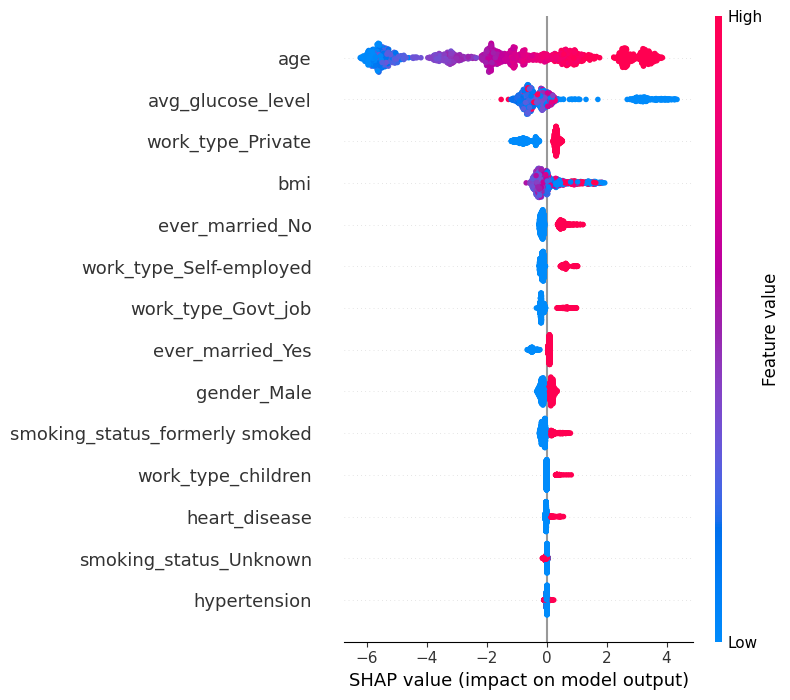

In [110]:
#model_name = [xgb]  # Use model objects, not strings
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.savefig('SHAP_values.png')
plt.show()

### split data and apply feature selection and SMOTE

In [98]:

##Selecting the features based on the formal feature selection.
selected_features = list(fs.top_features)

# Split features and labels
X = fs.getX()[selected_features]
y = fs.getY()

# Split data into training (60%), validation (20%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) 

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) # SMOTE on the scaled data
X_train_ns, y_train_ns = smote.fit_resample(X_train, y_train) # SMOTE on the non-scaled data


# ANN model

In [ ]:
# Train ANN model with SCALED SMOTE 
ann_model = Sequential()
ann_model.add(Input(shape=(X_train_resampled.shape[1],)))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(1, activation='sigmoid')) 

ann_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=500,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate ANN on validation and test sets
val_preds_ann = ann_model.predict(X_val_scaled)
val_preds_ann = (val_preds_ann > 0.5).astype(int)
test_preds_ann = ann_model.predict(X_test_scaled)
test_preds_ann = (test_preds_ann > 0.5).astype(int)

y_test_pred_proba_ann = ann_model.predict(X_test_scaled)
ann_auc_score = roc_auc_score(y_test, y_test_pred_proba_ann)

print("ANN Test AUC:", ann_auc_score)
print("ANN Validation Accuracy:", accuracy_score(y_val, val_preds_ann))
print("ANN Test Accuracy:", accuracy_score(y_test, test_preds_ann))
print("ANN Validation Classification Report:\n", classification_report(y_val, val_preds_ann))
print("ANN Test Classification Report:\n", classification_report(y_test, test_preds_ann))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
ANN Test AUC: 0.9540025994031001
ANN Validation Accuracy: 0.8950795947901592
ANN Test Accuracy: 0.8892908827785818
ANN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       940
           1       0.81      0.88      0.84       442

    accuracy                           0.90      1382
   macro avg       0.87      0.89      0.88      1382
weighted avg       0.90      0.90      0.90      1382

ANN Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       940
           1       0.81      0.86      0.83       442

    accuracy                           0.89      1382
   macro avg       0.87      0.88      0.87      1382
weighted avg       0.89      0.89      0.89      1382



# Logistic Regression model

In [ ]:
# Train Logistic Regression model with SCALED SMOTE
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

# Evaluate Logistic Regression
val_preds_lr = lr_model.predict(X_val_scaled)
test_preds_lr = lr_model.predict(X_test_scaled)

y_test_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_auc_score = roc_auc_score(y_test, y_test_pred_proba_lr)

print("Logistic Regression Test AUC:", lr_auc_score)
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, val_preds_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Logistic Regression Validation Classification Report:\n", classification_report(y_val, val_preds_lr, zero_division=0))  # set undefined precision to zero
print("Logistic Regression Test Classification Report:\n", classification_report(y_test, test_preds_lr, zero_division=0))  # set undefined precision to zero


Logistic Regression Test AUC: 0.9427337055935304
Logistic Regression Validation Accuracy: 0.8755426917510853
Logistic Regression Test Accuracy: 0.85383502170767
Logistic Regression Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       940
           1       0.75      0.91      0.82       442

    accuracy                           0.88      1382
   macro avg       0.85      0.89      0.86      1382
weighted avg       0.89      0.88      0.88      1382

Logistic Regression Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89       940
           1       0.72      0.89      0.80       442

    accuracy                           0.85      1382
   macro avg       0.83      0.86      0.84      1382
weighted avg       0.87      0.85      0.86      1382



In [101]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:\n", coef_df)

Logistic Regression Coefficients:
                            Feature  Coefficient
3                              age     3.624105
11              work_type_children     0.702497
1                    heart_disease     0.208773
10                             bmi     0.163091
12                 ever_married_No     0.158242
9                     hypertension     0.108707
4                      gender_Male     0.106030
6   smoking_status_formerly smoked     0.011153
2                work_type_Private    -0.101787
8               work_type_Govt_job    -0.104486
5                 ever_married_Yes    -0.158242
0           smoking_status_Unknown    -0.205457
13         work_type_Self-employed    -0.293523
7                avg_glucose_level    -0.404799


In this dataset, age has the strongest positive contributor to stroke risk.

# Gradient Boosting

### XGBoost

In [ ]:
# Train XGBoost WITH non-scaled SMOTE
xgb = XGBClassifier(
    use_label_encoder=False, # use_label_encoder=False to avoid deprecared automic encoding for target values
    eval_metric='logloss', 
    random_state=42, # random_state for reproducibility
    learning_rate=0.01, # smaller learning steps
    max_depth=4, # max depth
    #scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # balance classes
    subsample=0.8, # subsampling
    colsample_bytree=0.8, # column subsampling
    n_estimators=1000, # number of boosting rounds
)

xgb.fit(X_train_ns, y_train_ns)

# Evaluate XGBoost
val_preds_xgb = xgb.predict(X_val)
test_preds_xgb = xgb.predict(X_test)

y_test_pred_proba_XGBoost = xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = roc_auc_score(y_test, y_test_pred_proba_XGBoost)

print("XG Boost Test AUC:", xgb_auc_score)
print("XGBoost Validation Accuracy:", accuracy_score(y_val, val_preds_xgb))
print("XGBoost Test Accuracy:", accuracy_score(y_test, test_preds_xgb))
print("XGBoost Validation Classification Report:\n", classification_report(y_val, val_preds_xgb))
print("XGBoost Test Classification Report:\n", classification_report(y_test, test_preds_xgb))


C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:38:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XG Boost Test AUC: 0.9686916337729855
XGBoost Validation Accuracy: 0.914616497829233
XGBoost Test Accuracy: 0.9247467438494935
XGBoost Validation Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       940
           1       0.89      0.84      0.86       442

    accuracy                           0.91      1382
   macro avg       0.91      0.90      0.90      1382
weighted avg       0.91      0.91      0.91      1382

XGBoost Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       940
           1       0.89      0.87      0.88       442

    accuracy                           0.92      1382
   macro avg       0.92      0.91      0.91      1382
weighted avg       0.92      0.92      0.92      1382



### Light GBM

In [103]:

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_ns, y_train_ns)

#Evaluate Light GBM
val_preds_lgbm = lgb_model.predict(X_val)
test_preds_lgbm = lgb_model.predict(X_test)


# lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])
y_test_pred_proba_lgb = lgb_model.predict_proba(X_test)[:,1]

print("LGBM Validation Accuracy:", accuracy_score(y_val, val_preds_lgbm))
print("LGBM Test Accuracy:", accuracy_score(y_test, test_preds_lgbm))
print("LGBM Validation Classification Report:\n", classification_report(y_val, val_preds_lgbm))
print("LGBM Test Classification Report:\n", classification_report(y_test, test_preds_lgbm)) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2819, number of negative: 2819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 5638, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Validation Accuracy: 0.9059334298118669
LGBM Test Accuracy: 0.9066570188133141
LGBM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       940
           1       0.87      0.83      0.85       442

    accuracy                           0.91      1382
   macro avg       0.90      0.88      0.89      1382
weighted avg       0.91  

### Cat Boost

In [104]:
#df_cat = fs.copy(deep=True)
df_cat = df_combined.copy(deep=True)
#Fill missing values
# Separate numeric and categorical columns
#numeric_cols = df_cat.select_dtypes(include=[np.number]).columns

# Impute numeric columns with median
df_cat[numeric_cols] = SimpleImputer(strategy='median').fit_transform(df_cat[numeric_cols])

X_cat = df_cat.drop('stroke', axis=1)
y_cat = df_cat['stroke']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# 7. Get indices of categorical columns (for CatBoost)
cat_features_indices = [X_cat.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)

test_preds_cat = cat_model.predict(X_test_cat)

y_probs_cat = cat_model.predict_proba(X_test_cat)[:, 1]


print("Cat Test Accuracy:", accuracy_score(y_test, test_preds_cat))
print("Cat Test Classification Report:\n", classification_report(y_test, test_preds_cat)) 

Cat Test Accuracy: 0.9254703328509407
Cat Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       940
           1       0.92      0.84      0.88       442

    accuracy                           0.93      1382
   macro avg       0.92      0.90      0.91      1382
weighted avg       0.93      0.93      0.92      1382



# Support Vector Machine (SVM) Model

In [105]:
# Train SVM model with SCALED SMOTE
svm_model = SVC(kernel='linear', probability=True, random_state=42)  # Using linear kernel for SVM
svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate SVM Regression
val_preds_svm = svm_model.predict(X_val_scaled)
test_preds_svm = svm_model.predict(X_test_scaled)

y_test_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))
print("SVM Test Accuracy:", accuracy_score(y_test, test_preds_svm))
print("SVM Validation Classification Report:\n", classification_report(y_val, val_preds_svm, zero_division=0)) # set undefined precision to zero    
print("SVM Test Classification Report:\n", classification_report(y_test, test_preds_svm, zero_division=0)) # set undefined precision to zero

SVM Validation Accuracy: 0.88205499276411
SVM Test Accuracy: 0.8567293777134588
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       940
           1       0.77      0.91      0.83       442

    accuracy                           0.88      1382
   macro avg       0.86      0.89      0.87      1382
weighted avg       0.89      0.88      0.88      1382

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       940
           1       0.73      0.88      0.80       442

    accuracy                           0.86      1382
   macro avg       0.83      0.86      0.84      1382
weighted avg       0.87      0.86      0.86      1382



# Caculate and plot models confusion matrix and heatmap

In [106]:
# Create dictionary with model names and their predictions
models_predictions = {
    "ANN Classifier": test_preds_ann,
    "Logistic Regression": test_preds_lr,
    "XGBoost": test_preds_xgb,
    "Light GBM": test_preds_lgbm,
    "Cat Boost": test_preds_cat,
    "SVM": test_preds_svm
}

# Loop through each model and compute confusion matrix
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f"{model_name} Confusion Matrix:\n{conf_matrix}\n")

ANN Classifier Confusion Matrix:
[[851  89]
 [ 64 378]]

Logistic Regression Confusion Matrix:
[[788 152]
 [ 50 392]]

XGBoost Confusion Matrix:
[[893  47]
 [ 57 385]]

Light GBM Confusion Matrix:
[[878  62]
 [ 67 375]]

Cat Boost Confusion Matrix:
[[908  32]
 [ 71 371]]

SVM Confusion Matrix:
[[795 145]
 [ 53 389]]



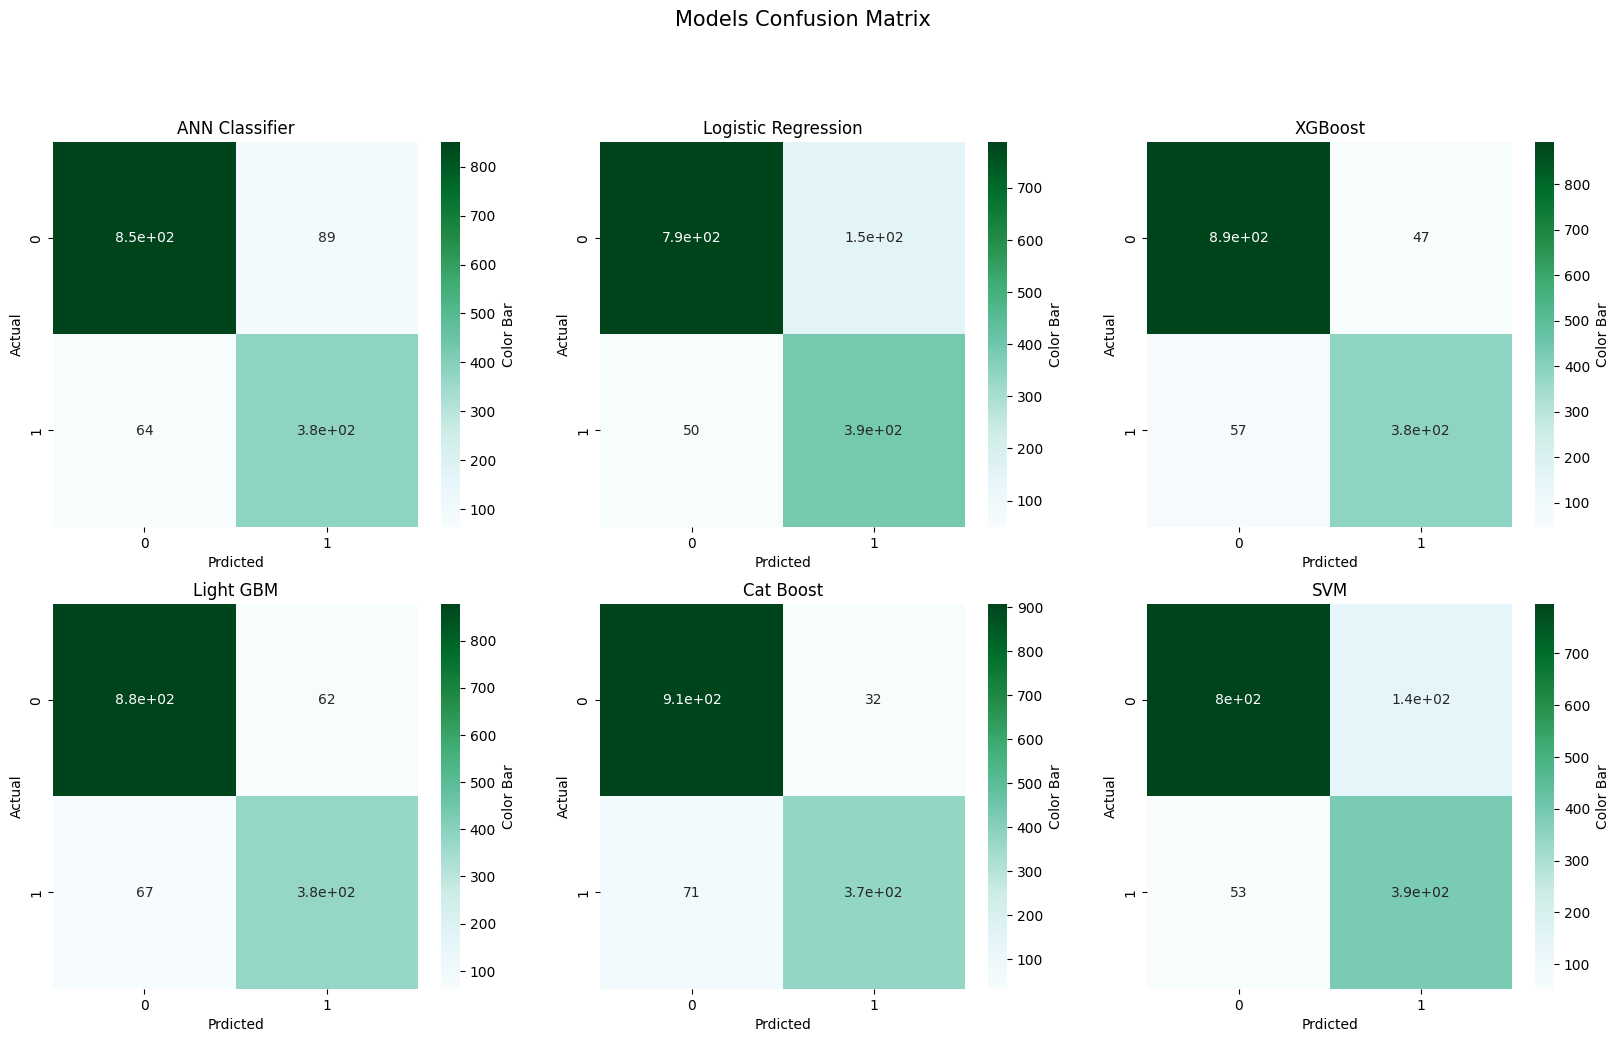

In [107]:
# Loop through each model and plot confusion matrix
plt_num = 1
plt.figure(figsize=(20,11)) # Set figure size
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.subplot(2, 3, plt_num)
    sns.heatmap(conf_matrix, cmap="BuGn", annot=True, cbar_kws={"label":"Color Bar"}) 
    plt.suptitle('Models Confusion Matrix', fontsize=15, y=1)  
    plt.title(model_name), plt.xlabel('Prdicted'), plt.ylabel('Actual')
    plt.savefig('Confusion_Matrix.png')
    plt_num +=1

# Reciever Characteristic Under Curve

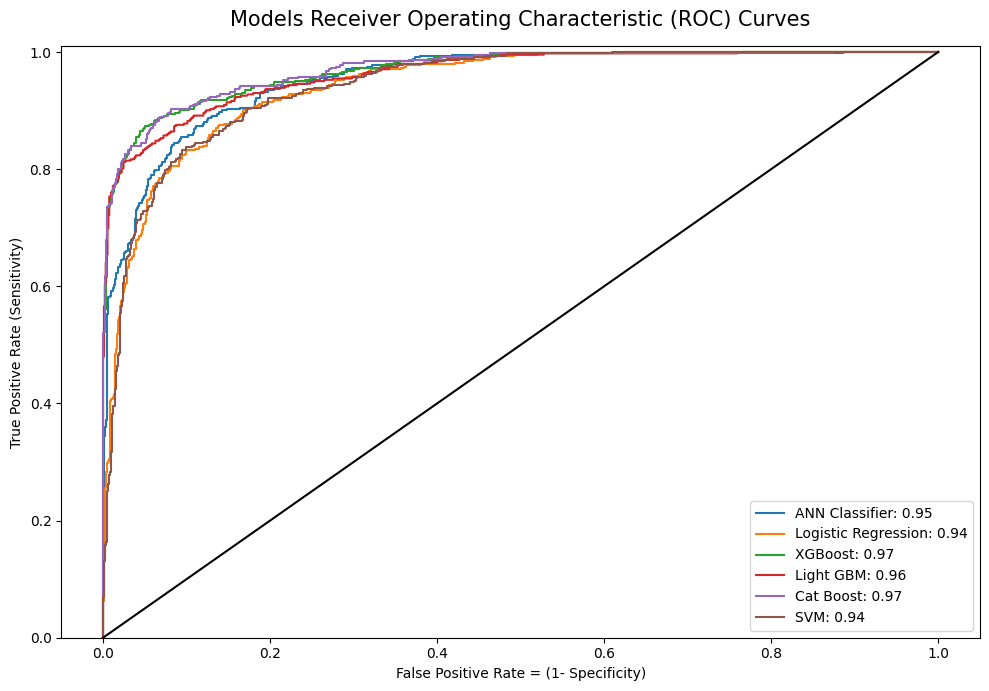

Models AUC Result 

ANN Classifier: AUROC = 0.95
Logistic Regression: AUROC = 0.94
XGBoost: AUROC = 0.97
Light GBM: AUROC = 0.96
Cat Boost: AUROC = 0.97
SVM: AUROC = 0.94


In [108]:
# Create dictionary with model names and their predictions
models_predictions = {
    "ANN Classifier": y_test_pred_proba_ann,
    "Logistic Regression": y_test_pred_proba_lr,
    "XGBoost": y_test_pred_proba_XGBoost,
    "Light GBM": y_test_pred_proba_lgb,
    "Cat Boost": y_probs_cat,
    "SVM": y_test_pred_proba_svm
}
    
# Create dictionary to store FPR and TPR for reach model
roc_results = {}
auc_results = {}

# Compute False Positive Rate and True Positive Rate, and Compute Area Under Receiver Operating Characteristic 
for model_name, predictions in models_predictions.items():
    fpr, tpr, threshold = roc_curve(y_test, predictions) # Compute False Positive Rate and True Positive Rate
    auc_results[model_name] = roc_auc_score(y_test, predictions) # Compute Area Under Receiver Operating Characteristic 
    roc_results[model_name] = (fpr, tpr)

plt.figure(figsize=(10, 7)) # set figure size

# Loop throup ROC results and plot the ROC Curves
for model_name, (fpr, tpr) in roc_results.items():
    plt.plot(fpr, tpr, label=f'{model_name}: {auc_results[model_name]:.2f}')

plt.plot([0, 1], [0, 1], 'k-')
plt.ylim([0.0, 1.01])
plt.title('Models Receiver Operating Characteristic (ROC) Curves', fontsize=15, y=1.02)  
plt.xlabel('False Positive Rate = (1- Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curves.png')  # Save the ROC curves figure as a PNG file to a file
plt.show()

# Print Models Area Under Receiver Operating Characteristic Results
print(f'Models AUC Result \n')
for model_name, auc in auc_results.items():
    print(f'{model_name}: AUROC = %.2f' % (auc))